In [17]:
from bitarray import bitarray
import random
import numpy as np
import math
import timeit

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [30]:
import pandas as pd
import os

In [31]:
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml
from sklearn import datasets

In [32]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target


In [33]:
X = StandardScaler().fit_transform(X)


In [34]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(50, 4)
(50, 4)


In [35]:
indices=np.arange(25)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:25]
x_train=np.concatenate((np.array(x_neg[0:25])[indices],x_pos)).reshape(-1,4)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [36]:
x_test = x_neg[25:50].reshape(-1,4)
y_test = y_neg[25:50].reshape(-1,1)

# Projection model

In [37]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

In [38]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values,times):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        start = timeit.default_timer()
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        stop = timeit.default_timer()
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f - Time Taken to create filter(sec): %f \n\n\n" % (m,fpr_test,stop-start))
        fpr_values += [fpr_test]
        size_values += [m]
        times += [stop-start]

In [39]:
num_of_iterations = 20 #Increase to make graph smoother

fpr_values = []
size_values = []
times = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,10,10,300,100,fpr_values,size_values,times)

~~~~~~~~ Iteration 1 ~~~~~~~~ 

(50, 4)
Size: 10 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040326 



Size: 20 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040960 



Size: 30 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.027526 



Size: 40 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.024982 



Size: 50 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.021015 



Size: 60 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.020306 



Size: 70 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.019747 



Size: 80 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.032043 



Size: 90 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.028523 



Size: 100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.023503 



Size: 110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.020656 



Size: 120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.023478 



Size: 130

Size: 1040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082744 



Size: 1050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.057284 



Size: 1060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060817 



Size: 1070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.058906 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107928 



Size: 1090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077057 



Size: 1100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.072443 



Size: 1110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083117 



Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065636 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085410 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078365 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081852 



Size: 1160 Bits - FPR: 0.000

Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101013 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129900 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120978 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151304 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.302347 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.252622 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.220907 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.235225 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.225258 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.209508 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.179521 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138678 



Size: 2180 Bits - FPR: 0.000

Size: 100 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.028820 



Size: 110 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.036332 



Size: 120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.031566 



Size: 130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.032297 



Size: 140 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.025600 



Size: 150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.032330 



Size: 160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.032673 



Size: 170 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.033481 



Size: 180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.038849 



Size: 190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.031033 



Size: 200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.030069 



Size: 210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.035024 



Size: 220 Bits - FPR: 0.000000 - Time Ta

Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088864 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079936 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079952 



Size: 1160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079716 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082532 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088722 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092329 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085360 



Size: 1210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083114 



Size: 1220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079869 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076307 



Size: 1240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076712 



Size: 1250 Bits - FPR: 0.000

Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147829 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142280 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.171861 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148234 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145957 



Size: 2210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101342 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104697 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103204 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107159 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108067 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107845 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104921 



Size: 2280 Bits - FPR: 0.000

Size: 190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.028735 



Size: 200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.026320 



Size: 210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.028055 



Size: 220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.026377 



Size: 230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.026461 



Size: 240 Bits - FPR: 0.120000 - Time Taken to create filter(sec): 0.028562 



Size: 250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.026291 



Size: 260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.028071 



Size: 270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.032415 



Size: 280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.027163 



Size: 290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.030547 



Size: 300 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.028861 



Size: 310 Bits - FPR: 0.000000 - Time Ta

Size: 1230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079128 



Size: 1240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078726 



Size: 1250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074861 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080696 



Size: 1270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076974 



Size: 1280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082736 



Size: 1290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088486 



Size: 1300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085567 



Size: 1310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083325 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082716 



Size: 1330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082711 



Size: 1340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086940 



Size: 1350 Bits - FPR: 0.000

Size: 2260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127902 



Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121534 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156436 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119791 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135041 



Size: 2310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134261 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127425 



Size: 2330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122823 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130620 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.162626 



Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142128 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.169014 



Size: 2380 Bits - FPR: 0.000

Size: 300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.036417 



Size: 310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.038182 



Size: 320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.034493 



Size: 330 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.033404 



Size: 340 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.035778 



Size: 350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.035542 



Size: 360 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.036950 



Size: 370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040225 



Size: 380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.036369 



Size: 390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.036015 



Size: 400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043064 



Size: 410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.035793 



Size: 420 Bits - FPR: 0.000000 - Time Ta

Size: 1340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080498 



Size: 1350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080109 



Size: 1360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081959 



Size: 1370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088537 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081482 



Size: 1390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081280 



Size: 1400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085159 



Size: 1410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087160 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082032 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093476 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083365 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085348 



Size: 1460 Bits - FPR: 0.000

Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.198415 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.169583 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126708 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125759 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126713 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134284 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127024 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.172345 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199841 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156222 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.210965 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.257195 



Size: 2480 Bits - FPR: 0.000

Size: 410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064350 



Size: 420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.064505 



Size: 430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074575 



Size: 440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110835 



Size: 450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151203 



Size: 460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076140 



Size: 470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.057727 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061014 



Size: 490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063995 



Size: 500 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.058909 



Size: 510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.070189 



Size: 520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.053604 



Size: 530 Bits - FPR: 0.000000 - Time Ta

Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078883 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.073331 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074867 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082403 



Size: 1470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074987 



Size: 1480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090793 



Size: 1490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078256 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074092 



Size: 1510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.074355 



Size: 1520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080024 



Size: 1530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079320 



Size: 1540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.075895 



Size: 1550 Bits - FPR: 0.000

Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114697 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113244 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114909 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113348 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114346 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111489 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116813 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114554 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120410 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118443 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.117051 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116683 



Size: 2580 Bits - FPR: 0.000

Size: 530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.038896 



Size: 540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045264 



Size: 550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040431 



Size: 560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043290 



Size: 570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.038023 



Size: 580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.042458 



Size: 590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048454 



Size: 600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.042846 



Size: 610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041549 



Size: 620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047238 



Size: 630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047143 



Size: 640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045249 



Size: 650 Bits - FPR: 0.000000 - Time Ta

Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081238 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076177 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.076353 



Size: 1590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081927 



Size: 1600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080575 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.080375 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084511 



Size: 1630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081438 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078769 



Size: 1650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083397 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083503 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081583 



Size: 1680 Bits - FPR: 0.000

Size: 2580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.271945 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125663 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195309 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131057 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122057 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118448 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121836 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.261849 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.184665 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.227483 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197226 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126030 



Size: 2700 Bits - FPR: 0.000

Size: 630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044213 



Size: 640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041370 



Size: 650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043767 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043260 



Size: 670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044238 



Size: 680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050275 



Size: 690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044129 



Size: 700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062889 



Size: 710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078072 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.058644 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047147 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.046531 



Size: 750 Bits - FPR: 0.000000 - Time Ta

Size: 1650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081625 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090365 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095076 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098480 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085046 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088608 



Size: 1710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085054 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091027 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085986 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100607 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086452 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086147 



Size: 1770 Bits - FPR: 0.000

Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.145580 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136829 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141738 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138901 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150564 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138834 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143111 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147540 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146824 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141869 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.146826 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151596 



Size: 2800 Bits - FPR: 0.000

Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050958 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055615 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049634 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050529 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052971 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051349 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047874 



Size: 790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049648 



Size: 800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051821 



Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.054058 



Size: 820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052468 



Size: 830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052418 



Size: 840 Bits - FPR: 0.000000 - Time Ta

Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132954 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100904 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176129 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.176819 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144776 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185111 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.262711 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177453 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110218 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.162885 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134010 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153311 



Size: 1870 Bits - FPR: 0.000

Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128143 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.136765 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129516 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127485 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131122 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134029 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133058 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127634 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132105 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130269 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130230 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159348 



Size: 2890 Bits - FPR: 0.000

Size: 790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.364387 



Size: 800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.196429 



Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152232 



Size: 820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.175907 



Size: 830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.184834 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.188648 



Size: 850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.197779 



Size: 860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.228655 



Size: 870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118685 



Size: 880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131960 



Size: 890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109989 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133044 



Size: 910 Bits - FPR: 0.000000 - Time Ta

Size: 1820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154379 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113566 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115736 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.222582 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.196371 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.237855 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.275022 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.194260 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.195226 



Size: 1910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.175580 



Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110283 



Size: 1930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132880 



Size: 1940 Bits - FPR: 0.000

Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.251341 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.187525 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.163555 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.449944 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.438103 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.328949 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.992040 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.415254 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.196426 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.236133 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.384815 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.331452 



Size: 2960 Bits - FPR: 0.000

Size: 880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060439 



Size: 890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056451 



Size: 900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055066 



Size: 910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062953 



Size: 920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104656 



Size: 930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077274 



Size: 940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083722 



Size: 950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061758 



Size: 960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.079097 



Size: 970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083879 



Size: 980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.170432 



Size: 990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147812 



Size: 1000 Bits - FPR: 0.000000 - Time T

Size: 1920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101032 



Size: 1930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095591 



Size: 1940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097884 



Size: 1950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107168 



Size: 1960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111041 



Size: 1970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101257 



Size: 1980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100614 



Size: 1990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100102 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105524 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098850 



Size: 2020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100665 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104867 



Size: 2040 Bits - FPR: 0.000

Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140719 



Size: 2950 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134681 



Size: 2960 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.138784 



Size: 2970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156829 



Size: 2980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139962 



Size: 2990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144764 



Size: 3000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.141872 



~~~~~~~~ Iteration 11 ~~~~~~~~ 

(50, 4)
Size: 10 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.029125 



Size: 20 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.024427 



Size: 30 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.026834 



Size: 40 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.022356 



Size: 50 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.022971 


Size: 970 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061202 



Size: 980 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.058160 



Size: 990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056834 



Size: 1000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060049 



Size: 1010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063061 



Size: 1020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.061037 



Size: 1030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060939 



Size: 1040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.059889 



Size: 1050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.065147 



Size: 1060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060185 



Size: 1070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062721 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.060482 



Size: 1090 Bits - FPR: 0.000000

Size: 1990 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098177 



Size: 2000 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103252 



Size: 2010 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098937 



Size: 2020 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102271 



Size: 2030 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106076 



Size: 2040 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101390 



Size: 2050 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099780 



Size: 2060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110575 



Size: 2070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100707 



Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099884 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106184 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106679 



Size: 2110 Bits - FPR: 0.000

Size: 20 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041704 



Size: 30 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.036148 



Size: 40 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.039700 



Size: 50 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051021 



Size: 60 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.049264 



Size: 70 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.036195 



Size: 80 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.034814 



Size: 90 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.027634 



Size: 100 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.024927 



Size: 110 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.028040 



Size: 120 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.024664 



Size: 130 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.035662 



Size: 140 Bits - FPR: 0.000000 - Time Taken to c

Size: 1060 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083395 



Size: 1070 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089995 



Size: 1080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.069189 



Size: 1090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.070193 



Size: 1100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063083 



Size: 1110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.063816 



Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.062663 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067916 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067279 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089768 



Size: 1160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.133196 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129291 



Size: 1180 Bits - FPR: 0.000

Size: 2080 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.228703 



Size: 2090 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.275855 



Size: 2100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.331924 



Size: 2110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.252072 



Size: 2120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.250066 



Size: 2130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.334400 



Size: 2140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.279824 



Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.263105 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151015 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135330 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.135766 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142108 



Size: 2200 Bits - FPR: 0.000

Size: 90 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.026435 



Size: 100 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.031440 



Size: 110 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.029692 



Size: 120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.031624 



Size: 130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048114 



Size: 140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.039403 



Size: 150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043892 



Size: 160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043741 



Size: 170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.039585 



Size: 180 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.075188 



Size: 190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040134 



Size: 200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.034175 



Size: 210 Bits - FPR: 0.000000 - Time Tak

Size: 1120 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.287842 



Size: 1130 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.254254 



Size: 1140 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.171002 



Size: 1150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.184934 



Size: 1160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112361 



Size: 1170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101833 



Size: 1180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128706 



Size: 1190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091314 



Size: 1200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085801 



Size: 1210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087345 



Size: 1220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.067398 



Size: 1230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098524 



Size: 1240 Bits - FPR: 0.000

Size: 2150 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149748 



Size: 2160 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150464 



Size: 2170 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153866 



Size: 2180 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150691 



Size: 2190 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.167522 



Size: 2200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.149315 



Size: 2210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.162394 



Size: 2220 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.134002 



Size: 2230 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.155364 



Size: 2240 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.160560 



Size: 2250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199957 



Size: 2260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.155514 



Size: 2270 Bits - FPR: 0.000

Size: 200 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044757 



Size: 210 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.035895 



Size: 220 Bits - FPR: 0.080000 - Time Taken to create filter(sec): 0.039403 



Size: 230 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.043526 



Size: 240 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.046259 



Size: 250 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.052248 



Size: 260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051143 



Size: 270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043180 



Size: 280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.041177 



Size: 290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047155 



Size: 300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.046141 



Size: 310 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.053495 



Size: 320 Bits - FPR: 0.000000 - Time Ta

Size: 1250 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098812 



Size: 1260 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101131 



Size: 1270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096858 



Size: 1280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095790 



Size: 1290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092133 



Size: 1300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100505 



Size: 1310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097140 



Size: 1320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099321 



Size: 1330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092644 



Size: 1340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098738 



Size: 1350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098182 



Size: 1360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090850 



Size: 1370 Bits - FPR: 0.000

Size: 2270 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154089 



Size: 2280 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.140391 



Size: 2290 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148034 



Size: 2300 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.143782 



Size: 2310 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152155 



Size: 2320 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.148597 



Size: 2330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158016 



Size: 2340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156936 



Size: 2350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.154235 



Size: 2360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.151049 



Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164631 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144222 



Size: 2390 Bits - FPR: 0.000

Size: 320 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.048469 



Size: 330 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.042620 



Size: 340 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.040926 



Size: 350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048903 



Size: 360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.042829 



Size: 370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055580 



Size: 380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045517 



Size: 390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.042290 



Size: 400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047702 



Size: 410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048119 



Size: 420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.081271 



Size: 430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.046719 



Size: 440 Bits - FPR: 0.000000 - Time Ta

Size: 1350 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099428 



Size: 1360 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.096997 



Size: 1370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095633 



Size: 1380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102471 



Size: 1390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102700 



Size: 1400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097355 



Size: 1410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105845 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100357 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100757 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098397 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110703 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102853 



Size: 1470 Bits - FPR: 0.000

Size: 2370 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158787 



Size: 2380 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.223406 



Size: 2390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.248868 



Size: 2400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.142919 



Size: 2410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.161882 



Size: 2420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152680 



Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159121 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.150438 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.147776 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156437 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.161157 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.152949 



Size: 2490 Bits - FPR: 0.000

Size: 390 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052213 



Size: 400 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.042930 



Size: 410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045378 



Size: 420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.046586 



Size: 430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043647 



Size: 440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051614 



Size: 450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.056855 



Size: 460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047933 



Size: 470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050574 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047928 



Size: 490 Bits - FPR: 0.040000 - Time Taken to create filter(sec): 0.056620 



Size: 500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049063 



Size: 510 Bits - FPR: 0.000000 - Time Ta

Size: 1410 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106123 



Size: 1420 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.097363 



Size: 1430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.101171 



Size: 1440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100551 



Size: 1450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103000 



Size: 1460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108150 



Size: 1470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098321 



Size: 1480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.106166 



Size: 1490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.102726 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111218 



Size: 1510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.100756 



Size: 1520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.108676 



Size: 1530 Bits - FPR: 0.000

Size: 2430 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.322726 



Size: 2440 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.196000 



Size: 2450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.157278 



Size: 2460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.199866 



Size: 2470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.229024 



Size: 2480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.177965 



Size: 2490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159871 



Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.153140 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164805 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.166899 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.185675 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.165814 



Size: 2550 Bits - FPR: 0.000

Size: 450 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.054047 



Size: 460 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050938 



Size: 470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.059605 



Size: 480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.054031 



Size: 490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.053508 



Size: 500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048553 



Size: 510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052248 



Size: 520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.058608 



Size: 530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055941 



Size: 540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.059559 



Size: 550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050832 



Size: 560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052008 



Size: 570 Bits - FPR: 0.000000 - Time Ta

Size: 1470 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103886 



Size: 1480 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.144255 



Size: 1490 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105732 



Size: 1500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113739 



Size: 1510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.104373 



Size: 1520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.114726 



Size: 1530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.110202 



Size: 1540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105528 



Size: 1550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.115226 



Size: 1560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.103398 



Size: 1570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.112199 



Size: 1580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.107113 



Size: 1590 Bits - FPR: 0.000

Size: 2500 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.156893 



Size: 2510 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159580 



Size: 2520 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.163101 



Size: 2530 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.157066 



Size: 2540 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164944 



Size: 2550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.159557 



Size: 2560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.171104 



Size: 2570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.162183 



Size: 2580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.166130 



Size: 2590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.163667 



Size: 2600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.168111 



Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.164963 



Size: 2620 Bits - FPR: 0.000

Size: 550 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.105923 



Size: 560 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091998 



Size: 570 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083275 



Size: 580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099872 



Size: 590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090075 



Size: 600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.077663 



Size: 610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091696 



Size: 620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.099611 



Size: 630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085396 



Size: 640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.086958 



Size: 650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.098785 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.078459 



Size: 670 Bits - FPR: 0.000000 - Time Ta

Size: 1580 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.109601 



Size: 1590 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111285 



Size: 1600 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.116334 



Size: 1610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113204 



Size: 1620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.113656 



Size: 1630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.111363 



Size: 1640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.121708 



Size: 1650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.157440 



Size: 1660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183531 



Size: 1670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.183953 



Size: 1680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.225573 



Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.265822 



Size: 1700 Bits - FPR: 0.000

Size: 2610 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125819 



Size: 2620 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.118791 



Size: 2630 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.120632 



Size: 2640 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122534 



Size: 2650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125258 



Size: 2660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.119473 



Size: 2670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132046 



Size: 2680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124211 



Size: 2690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158070 



Size: 2700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.122711 



Size: 2710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131302 



Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126293 



Size: 2730 Bits - FPR: 0.000

Size: 650 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.045638 



Size: 660 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049861 



Size: 670 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.046937 



Size: 680 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043494 



Size: 690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043932 



Size: 700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.043900 



Size: 710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047391 



Size: 720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.044558 



Size: 730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049860 



Size: 740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.047672 



Size: 750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052934 



Size: 760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052737 



Size: 770 Bits - FPR: 0.000000 - Time Ta

Size: 1690 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084747 



Size: 1700 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.082845 



Size: 1710 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.083739 



Size: 1720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084127 



Size: 1730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090517 



Size: 1740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084546 



Size: 1750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091291 



Size: 1760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.085914 



Size: 1770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084540 



Size: 1780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087945 



Size: 1790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.089877 



Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.084367 



Size: 1810 Bits - FPR: 0.000

Size: 2720 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125600 



Size: 2730 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.125179 



Size: 2740 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.124595 



Size: 2750 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126618 



Size: 2760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127830 



Size: 2770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130018 



Size: 2780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127843 



Size: 2790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127092 



Size: 2800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.126638 



Size: 2810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128612 



Size: 2820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128812 



Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131778 



Size: 2840 Bits - FPR: 0.000

Size: 760 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049851 



Size: 770 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052027 



Size: 780 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048102 



Size: 790 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.048914 



Size: 800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049434 



Size: 810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.055193 



Size: 820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050370 



Size: 830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.050101 



Size: 840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.049083 



Size: 850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.051473 



Size: 860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052098 



Size: 870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.052335 



Size: 880 Bits - FPR: 0.000000 - Time Ta

Size: 1800 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088713 



Size: 1810 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091258 



Size: 1820 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090969 



Size: 1830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093927 



Size: 1840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.088572 



Size: 1850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.090374 



Size: 1860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.094568 



Size: 1870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.087585 



Size: 1880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.093341 



Size: 1890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.095142 



Size: 1900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.091256 



Size: 1910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.092505 



Size: 1920 Bits - FPR: 0.000

Size: 2830 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130801 



Size: 2840 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.266668 



Size: 2850 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.158986 



Size: 2860 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.129820 



Size: 2870 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.127726 



Size: 2880 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.128864 



Size: 2890 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130734 



Size: 2900 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132608 



Size: 2910 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.139911 



Size: 2920 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.131952 



Size: 2930 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.130259 



Size: 2940 Bits - FPR: 0.000000 - Time Taken to create filter(sec): 0.132590 



Size: 2950 Bits - FPR: 0.000

In [40]:
total_fprs = len(fpr_values)
average_fprs = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += fpr_values[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_fprs += [temp]
print(len(average_fprs))

300


In [41]:
total_times = len(times)
average_times = []
for i in range(0,total_fprs//num_of_iterations):
    temp = 0
    for j in range(0,num_of_iterations):
        temp += times[i+j*(total_fprs//num_of_iterations)]
    temp /= num_of_iterations
    average_times += [temp]
print(len(average_times))

300


# Normal Bloom Filter Values

In [42]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [43]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

6000
[50]


# FPR Comparison between Projection Model and Normal Bloom Filter

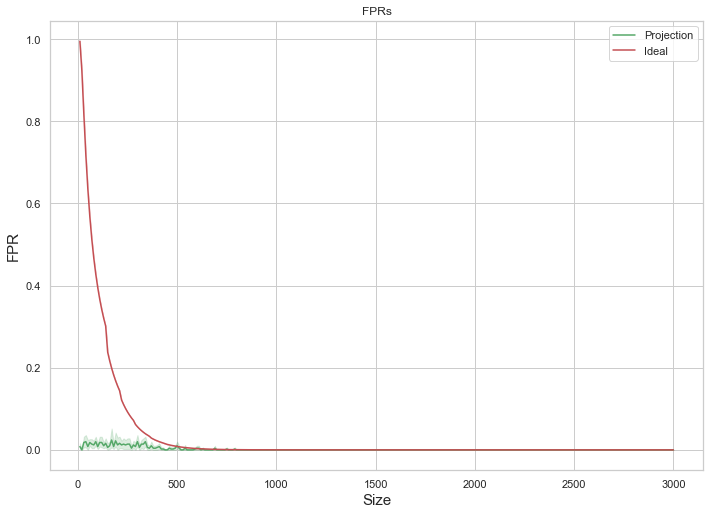

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [45]:
average_fprs = num_of_iterations*average_fprs
print(len(average_fprs))

6000


In [46]:
average_times = num_of_iterations*average_times
print(len(average_times))

6000


In [47]:
print(average_fprs)

[0.008, 0.0, 0.018, 0.019999999999999997, 0.008, 0.018, 0.014000000000000002, 0.012, 0.019999999999999997, 0.008, 0.018, 0.018, 0.01, 0.016, 0.006, 0.01, 0.023999999999999997, 0.008, 0.022, 0.012, 0.016, 0.012, 0.014000000000000002, 0.012, 0.014000000000000002, 0.014000000000000002, 0.004, 0.012, 0.008, 0.019999999999999997, 0.006, 0.013999999999999999, 0.014000000000000002, 0.02, 0.006, 0.004, 0.01, 0.004, 0.004, 0.006, 0.008, 0.002, 0.002, 0.0, 0.0, 0.004, 0.002, 0.002, 0.004, 0.01, 0.004, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.002, 0.004, 0.004, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
saved_data = list(zip(size_values, y_ideal, fpr_values, average_fprs, times, average_times))
df = pd.DataFrame(saved_data,columns = ['Size of filter(bits)','Ideal FPR', 'Projection FPR for iteration', 'Average Projection FPR', 'Projection Filter Total Creation Time(sec)', 'Average Projection Filter Total Creation Time(sec)'])
df.head()

In [ ]:
df.to_csv('/Users/aditijain/Desktop/NewFolderWithItems/SURA/Iris_rerun_epochs_100.csv')